# Background Blurring, Part 2
> "Using our trained model to blur the background of video frames."

- toc: true
- branch: master
- badges: true
- comments: false
- categories: [opencv, privacy]
- image: images/articles/2020-12-16-midlevel-api/datasets-title.png
- hide: false

In [2]:
#hide
!pip install fastai==2.2.5 opencv-python -q

In [22]:
from fastai.vision.all import *
import cv2

## Load Learner

The `Learner` expects to find all functions that were defined when creating it. We don't need any custom functionality however, so we define an empty `create_mask` function.

In [23]:
def create_mask(): pass

Load a `learner` and get predictions of one training image.

In [24]:
learn = load_learner('export.pkl')
fnames = get_image_files('training')
preds = learn.predict(fnames[1])

There are different images in the prediction.

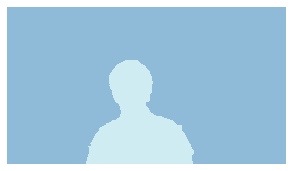

In [25]:
preds[0].show(vmin=0,vmax=1);

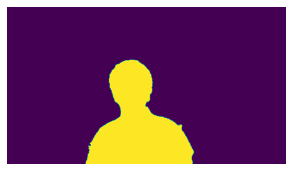

In [11]:
preds[1].show();

In [12]:
preds[2].shape

(2, 360, 640)

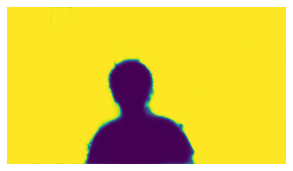

In [13]:
preds[2][0].show();

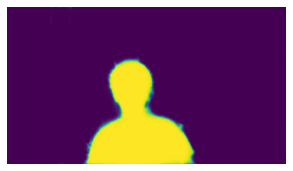

In [14]:
preds[2][1].show();

We will use `preds[1]` as it has the format we require (just `0`s and `1`s)

## Capture Video

As for now, we just work with a saved video file. To work with live webcam video, we would have to increase the speed of the inference process by a lot. On my current Paperspace Gradient machine (P4000) it runs at about 0.5 FPS....

Let's define a simple blur function.

In [15]:
def blur(img: np.ndarray, kernel_size=5, sigma_x=0) -> np.ndarray:
    # Make sure that kernel size is an odd number
    if kernel_size % 2 == 0:
        kernel_size += 1
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), sigma_x)

Setting up video files. `testclip.mp4` is a video I shot with my webcam.

In [32]:
cap = cv2.VideoCapture('testclip.mp4')
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output/blurred-testclip.mp4', fourcc, 25, (640, 360))

### Loop through frames

In [33]:
i = 0
while cap.isOpened() and i<1:
    # Capture frame
    ret, frame = cap.read()
    
    # Break loop at end of video
    if ret == False:
        break
    
    # Resize frame and save to disk
    frame = cv2.resize(frame, (640,360), interpolation=cv2.INTER_AREA)
    cv2.imwrite('output/frame_'+str(i)+'.jpg',frame)       
    
    # Run inference and create True/False mask from result
    preds = learn.predict('output/frame_'+str(i)+'.jpg') 
    mask = np.array(preds[1] > 0)
    
    # Blur background
    output = blur(frame, kernel_size=61) 
    
    # Replace area of person with the unblurred original frame
    output[mask] = frame[mask]
    
    # Write frame to video
    out.write(output)
    
    # Save every 25th output as jpg, just to find a good thumbnail :)
    if i == 0 or i%25 == 0:
        cv2.imwrite('output/output_'+str(i)+'.jpg', output) 
    
    # Remove saved frame
    os.remove('output/frame_'+str(i)+'.jpg')

    # Increase counter
    i += 1
    
# Release opened files
cap.release()
out.release()

Let's look at a single frame:

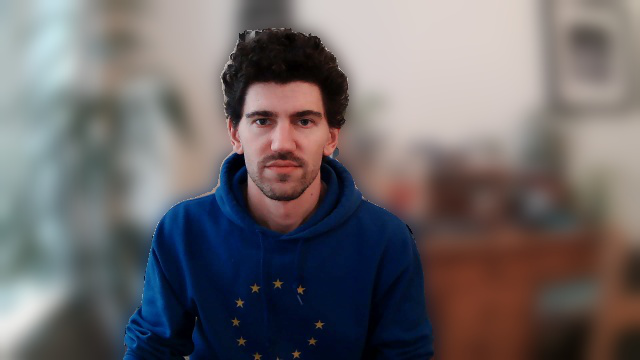

In [18]:
PILImage.create('output/output_0.jpg')

This looks pretty good! There are some rough edges, but overall I'm happy with the result for this little project.

## To Do

The biggest thing to improve now is inference speed. As I mentioned, the current implementation works only with video files, not live video, and it runs at about 0.5 frames per second 🥴 The U-Net is a pretty heavy model, even with the relatively small Resnet18 backbone. The saved weights are 167MB. This alone is reason enough for the model to run slow. Since we run the model frame by frame, the GPU is not helping much because there is no parallelization. The current implementation is also inconvenient because it relies on opening an image file from disk. The model should be able to run on an opened image (= numpy array) directly.

The next step would be better generalization. I suspect that this model is currently very much optimized for myself. If we wanted to roll this out as a feature for many people, we would have to include many people and different backgrounds, cameras, and lightning situations.